# Assignment 1: Camera Calibration
<div align="left">
- Aman Joshi
- 2018201097
    </div>

In [10]:
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sympy import Matrix
import random
import cv2 as cv
from math import sqrt
import matplotlib.pyplot as plt

# Camera class 
The class represent a camera that has some parameters like **K, R, P, t**. It also contain functions like :
- get_camera_parameters: It will calculate camera parameters using DLT. 
- get_image_coordinates: It will map a 3-D real world point to 2-D image point.
- RANSAC: It will calculate camera parameters using DLT.

## DLT
It is a Camera Calibration technique that require mapping of 3D real world coordinates to 2D image coordinates. The real world coordinates can be represented as\begin{equation*}
X = [x\ y\ z\ w]
\end{equation*}
while the image coordinates can be represented as \begin{equation*}
\bar{x} = [u\ v\ w]
\end{equation*}
the transformation from 3D points to 2D points can be done through a **3 X 3** matrix **P** .
Thus combining above 
\begin{equation}\label{eq:}
X = P\bar{x}
\end{equation}

Where P is the camera matrix and can be represented as\begin{equation*}
P = K[R|t] = KR|Kt
\end{equation*}
Where __K__ is the intrinsic parameters of camera while **R** , **t** are rotational and transational matrices and vectors.

However this can be further solved using\begin{equation*}
KR*(KR)^T = KK^T
\end{equation*}
It can be solved to find K which then can be used to find R and t.
## RANSAC
Random sample consensus (RANSAC) is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates. Therefore, it also can be interpreted as an outlier detection method.
I ve set number of iterations to be 100 and threshold to 200. Where 200 is the allowed euclidean distance. 

In [11]:
class Camera:
    def __init__(self):
        self.P = None
        self.K = self.R = self.C = None

    def change_K(self, K):
        self.K = np.array(K)
        self.KR = np.dot(self.K, self.R)
        self.Kt = np.dot(self.K, self.t)
        #         display(self.K, self.R, self.t, self.KR, self.Kt)
        self.P = np.concatenate((self.KR, self.Kt), axis=1)

    def get_camera_parameters(self,
                              real_world_coordinates,
                              image_coordinates,
                              change=True):
        size = len(real_world_coordinates) * 2
        A = np.empty(shape=(size, 12))
        count = 0
        for real_point, image_point in zip(real_world_coordinates,
                                           image_coordinates):
            #             print(real_point, image_point)
            A[count] = np.array([
                -real_point[0], -real_point[1], -real_point[2], -1, 0, 0, 0, 0,
                real_point[0] * image_point[0], real_point[1] * image_point[0],
                real_point[2] * image_point[0], image_point[0]
            ])
            A[count + 1] = np.array([
                0, 0, 0, 0, -real_point[0], -real_point[1], -real_point[2], -1,
                real_point[0] * image_point[1], real_point[1] * image_point[1],
                real_point[2] * image_point[1], image_point[1]
            ])
            count += 2


#         print(A)
#         return A
        S, V, d = np.linalg.svd(A)
        #         print(d)
        P = d[-1, :] / d[-1, -1]
        P = np.reshape(P, (3, 4))
        if change:
            self.P = P
        return P

    def get_KRC(self, change=True):
        KR = self.P[np.ix_([0, 1, 2], [0, 1, 2])]
        #         print("KR = ", KR)
        KRC = self.P[np.ix_([0, 1, 2], [3])]
        temp = np.dot(KR, KR.T)
        temp = temp / temp[2][2]
        #         print("TEMP = ", temp)
        u0 = temp[2][0]
        v0 = temp[2][1]
        beta = np.sqrt(temp[1][1] - v0 * v0)
        gamma = (temp[1][0] - u0 * v0) / beta
        alpha = np.sqrt(temp[0][0] - gamma**2 - u0**2)
        self.K = np.array([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
        inverse = np.linalg.inv(self.K)
        self.R = np.dot(inverse, KR)
        self.t = np.dot(inverse, KRC)
        return self.K, self.R, self.t

    def get_image_coordinates(self, real_world_coordinates):
        image_coordinates = []
        #         print(real_world_coordinates)
        for world_point in real_world_coordinates:
            world_point = np.array(world_point)
            #             print(world_point)
            #             world_point.append(1)
            #             print(world_point)
            world_point = np.append(world_point, 1)
            #             print(world_point_)?
            res = np.dot(self.P, world_point.T)
            image_coordinates.append(res[:2] / res[2])
        return np.array(image_coordinates)

    def error(self, X, Y):
        return np.mean(np.sqrt([(x - y)**2 for x, y in zip(X, Y)]))

    def RANSAC(self,
               real_world_coordinates,
               image_coordinates,
               iterations,
               threshold=200,
               d=1):
        iter = 0
        best_fit = None
        best_error = 1e+30
        while iter < iterations:
            index = random.sample([i for i in range(len(image_coordinates))],
                                  6)
            model_real_world_coordinates = [
                real_world_coordinates[i] for i in index
            ]
            model_image_coordinates = [image_coordinates[i] for i in index]
            P = self.get_camera_parameters(model_real_world_coordinates,
                                           model_image_coordinates)
            no_of_inliners = 0
            error = 0.0
            check_real_world_coordinates = [
                real_world_coordinates[i]
                for i in range(len(real_world_coordinates)) if i not in index
            ]
            check_image_coordinates = [
                image_coordinates[i] for i in range(len(image_coordinates))
                if i not in index
            ]
            predicted_image_coordinates = self.get_image_coordinates(
                check_real_world_coordinates)
            points_with_allowed_error = [
                self.error(x, y) for x, y in zip(check_image_coordinates,
                                                 predicted_image_coordinates)
            ]
            #             print("fhdskfhadgfdafadslf", points_with_allowed_error)
            index = []
            for i in range(len(points_with_allowed_error)):
                if points_with_allowed_error[i] < threshold:
                    index.append(i)
            points_with_allowed_error = [
                i for i in points_with_allowed_error if i < threshold
            ]
            #             print(
            #                 "Hey there delilah whats it like in new york city I am thousand",
            #                 points_with_allowed_error)
            if len(points_with_allowed_error) > d:
                model_real_world_coordinates = [
                    real_world_coordinates[i] for i in index
                ]
                model_image_coordinates = [image_coordinates[i] for i in index]
                P = self.get_camera_parameters(model_real_world_coordinates,
                                               model_image_coordinates)
                points_with_allowed_error = [
                    self.error(x, y) for x, y in zip(
                        check_image_coordinates, predicted_image_coordinates)
                ]
                cur_error = np.mean(points_with_allowed_error)
                if cur_error < best_error:
                    best_fit = P
                    best_error = cur_error
            iter += 1
        self.P = best_fit
        return self.get_KRC()

# Question 1 (DLT)

In [12]:
real_world_coordinates = [[0, 0, 0], [0, 12.3, 0],
                          [14.5, 12.3, 0], [14.5, 0, 0], [0, 0, 14.5],
                          [0, 12.3,
                           14.5]]  #, [14.5,12.3,14.5]]#, [14.5,0,14.5]]
image_coordinates = [[1302, 1147], [1110, 976], [1411, 863], [1618, 1012],
                     [1324, 812], [1127, 658]]  #,[1433,564]]#,[1645,704]]
image = [[120.855, 285.603], [904.145, 329.632], [3242.98, 462.119],
         [4070.4, 506.248], [4919.89, 561.41], [198.081, 1046.83],
         [926.21, 1101.99], [1676.4, 1157.15], [2448.66, 1212.31],
         [3220.92, 1267.47], [4026.27, 1333.67], [4875.76, 1388.83],
         [661.435, 2105.93], [1433.69, 2172.12], [2216.98, 2238.31],
         [3033.37, 2315.54], [3860.79, 2381.73], [4721.31, 2458.96],
         [330.468, 2403.8], [1146.85, 2469.99], [3717.37, 2712.7],
         [4655.11, 2800.96], [826.919, 2823.02], [2614.15, 2999.54],
         [3562.92, 3087.8], [4544.79, 3165.02], [462.855, 3231.22],
         [1400.6, 3319.47], [2371.44, 3407.02], [3375.37, 3507.31]]
image = np.array(image)
obj = [[6, 2, 0], [5, 2, 0], [2, 2, 0], [1, 2, 0], [0, 2, 0], [6, 1, 0],
       [5, 1, 0], [4, 1, 0], [3, 1, 0], [2, 1, 0], [1, 1, 0], [0, 1, 0],
       [5, 0, 1], [4, 0, 1], [3, 0, 1], [2, 0, 1], [1, 0, 1], [0, 0, 1],
       [5, 0, 2], [4, 0, 2], [1, 0, 2], [0, 0, 2], [4, 0, 3], [2, 0, 3],
       [1, 0, 3], [0, 0, 3], [4, 0, 4], [3, 0, 4], [2, 0, 4], [1, 0, 4]]
obj = np.array(obj) * 36

In [13]:
camera = Camera()
A = camera.get_camera_parameters(obj[:-3], image[:-3])
camera.get_KRC()

(array([[ 1.25885915e+04, -1.58399428e+02,  2.99455515e+03],
        [ 0.00000000e+00,  1.25730165e+04,  2.55155358e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.75295596e-03,  1.29223954e-05, -3.80676721e-04],
        [-1.58756129e-04, -1.65446782e-03,  6.74884489e-04],
        [ 3.46234380e-04, -6.93185107e-04, -1.61788519e-03]]),
 array([[ 0.14284853],
        [-0.0312802 ],
        [ 1.        ]]))

In [14]:
display(camera.get_image_coordinates(obj[-3:]), image[-3:])

array([[1399.86342903, 3313.63124042],
       [2376.7373707 , 3416.36005284],
       [3384.85276629, 3522.37424049]])

array([[1400.6 , 3319.47],
       [2371.44, 3407.02],
       [3375.37, 3507.31]])

In [15]:
print(np.multiply(camera.R, camera.R.T))

[[ 3.07285459e-06 -2.05150946e-09 -1.31803368e-07]
 [-2.05150946e-09  2.73726376e-06 -4.67819877e-07]
 [-1.31803368e-07 -4.67819877e-07  2.61755250e-06]]


# Question 2 (RANSAC)

In [7]:
def RMSError(preds, actual):
    return np.sqrt(np.sum((preds - actual)**2, axis=1))

In [8]:
camera.RANSAC(obj, image, iterations=100)

/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/aman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


(array([[ 1.24251814e+04, -1.23733323e+02,  2.96846809e+03],
        [ 0.00000000e+00,  1.24048548e+04,  2.59598622e+03],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.77600532e-03,  1.25884537e-05, -3.94470885e-04],
        [-1.64938377e-04, -1.67567035e-03,  6.89118880e-04],
        [ 3.58554153e-04, -7.08470910e-04, -1.63690822e-03]]),
 array([[ 0.14703913],
        [-0.03498347],
        [ 1.        ]]))

# Question 3
Error in DLT and RANSAC

In [9]:
predicted_point = camera.get_image_coordinates(obj)
# print(predicted_point.shape, image.shape)
print("Ransac", np.mean(RMSError(image, predicted_point)))

Ransac 9.875299761233322


In [10]:
camera = Camera()
A = camera.get_camera_parameters(obj, image)
predicted_point = camera.get_image_coordinates(obj)
# print(predicted_point.shape, image.shape)
print("DLT", np.mean(RMSError(image, predicted_point)))

DLT 9.05262280856669


# Question 4 and Question 6

We are given images of checker board. The checkerboard has inner point of shape **8X6**. I've used findChessboardCorners to find corners that are inside. 
Then I've used cv.cameraCalibrate function It resturns the distortion matrix.
Using this distortion matrix and camera matrix we can find new camera matrix.
Which in then used to undistort image.

In [11]:
from glob import glob
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6 * 8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2)
objpoints = []
imgpoints = []
img_path = glob('*.JPG')

In [12]:
img_path.remove("IMG_5455.JPG")
for path in img_path:
    img = cv.imread(path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (8, 6), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
        cv.waitKey(2000)
    cv.destroyAllWindows()

In [13]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, (gray.shape[1], gray.shape[0]), None, None)

In [14]:
mtx

array([[1.36415094e+04, 0.00000000e+00, 3.31635881e+03],
       [0.00000000e+00, 1.36632517e+04, 1.50037396e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

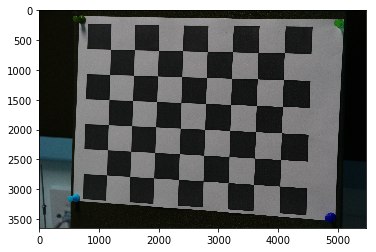

In [15]:
im___ = cv.imread("IMG_5457.JPG")
plt.imshow(im___)

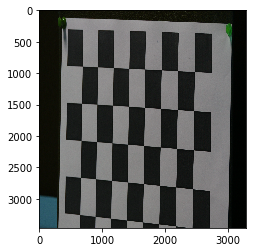

In [16]:
h, w = im___.shape[:2]
new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1,
                                                   (w, h))
# print(new_camera_mtx, mtx)
dst = cv.undistort(im___, mtx, dist, None, new_camera_mtx)
x, y, w, h = roi
dst = cv.resize(dst, (h, w))
dst = dst[y:y + h, x:x + w]
# print(dst)
plt.imshow(dst)
cv.imwrite("undistorted.jpg", dst)
cv.waitKey(2000)
cv.destroyAllWindows()

In [17]:
display("ret", ret)
display("mtx", mtx)
display("dist", dist)
display("rvecs", rvecs)
display("tvecs", tvecs)

'ret'

2.2884151455296062

'mtx'

array([[1.36415094e+04, 0.00000000e+00, 3.31635881e+03],
       [0.00000000e+00, 1.36632517e+04, 1.50037396e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

'dist'

array([[ 9.79057908e-02,  9.45876425e+00, -1.53012034e-02,
         2.72096493e-02, -1.48434591e+02]])

'rvecs'

[array([[ 0.224736  ],
        [-0.40391396],
        [-0.05729597]]), array([[-0.38062218],
        [ 0.00937555],
        [ 0.06939662]]), array([[-0.19331795],
        [-0.38351388],
        [-0.00385092]]), array([[ 0.24480949],
        [-0.32074973],
        [ 0.02437853]]), array([[-0.00934508],
        [-0.41443156],
        [-0.03564632]]), array([[-0.44170342],
        [-0.42401968],
        [ 0.05266029]]), array([[ 0.01632709],
        [-0.61709955],
        [-0.07773616]]), array([[-0.01040574],
        [-0.04719484],
        [-0.00305521]]), array([[0.00513069],
        [0.30996097],
        [0.06536842]]), array([[-0.32562264],
        [-0.22056304],
        [-0.01697744]]), array([[0.3105252 ],
        [0.0684347 ],
        [0.07015431]]), array([[-0.37489968],
        [-0.48549731],
        [ 0.02866769]]), array([[ 0.34965336],
        [-0.56196712],
        [-0.06068481]]), array([[-0.11408779],
        [-0.29596135],
        [ 0.00481932]]), array([[-0.00628759],
   

'tvecs'

[array([[-4.63768612],
        [-0.89986242],
        [38.70403393]]), array([[-4.20789684],
        [-2.26805866],
        [35.06790501]]), array([[-3.54440684],
        [-2.03938703],
        [31.92571791]]), array([[-5.59967776],
        [-1.21713138],
        [34.98571624]]), array([[-4.48832387],
        [-1.77689402],
        [28.99878095]]), array([[-4.4561796 ],
        [-2.28203658],
        [33.30645999]]), array([[-4.11373552],
        [-1.74328426],
        [28.33627768]]), array([[-5.09954028],
        [-2.0599507 ],
        [30.85011107]]), array([[-4.76286421],
        [-2.13319095],
        [32.66230913]]), array([[-5.10103684],
        [-1.86779325],
        [35.9587791 ]]), array([[-5.26909064],
        [-1.69789282],
        [30.50435301]]), array([[-5.12745147],
        [-2.04767454],
        [34.70799057]]), array([[-2.12512359],
        [-1.32570061],
        [29.33561584]]), array([[-4.13203861],
        [-1.94212036],
        [38.58165265]]), array([[-5.02987713

## Radial Distortion 
- k1 =  9.79057908e-02
- k2 = 9.45876425e+00
- p1 = -1.53012034e-02,
- p2 = 2.72096493e-02
- k3 = -1.48434591e+02

# Question 5

I have drawn image of 3-D cube. I have taken a unit cube with one point at origin. Then used the calculated camera matrix form DLT to find image coordinates. 
These points are then connected to form cube.

(365, 548, 3) (365, 548, 3)


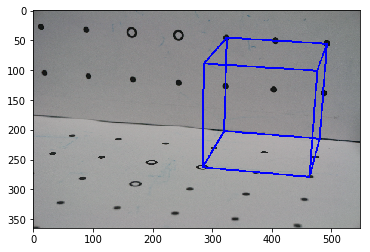

In [18]:
measurement = cv.imread("measurements.jpg")
wireframe_iamge = cv.imread("IMG_5455.JPG")
wireframe_iamge = cv.resize(wireframe_iamge, (548, 365))
print(measurement.shape, wireframe_iamge.shape)
i = 0
predicted_points = camera.get_image_coordinates(obj)
_3d_corners = np.float32([[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1],
                          [0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]]) * 72
cube_corners_2d = np.array(camera.get_image_coordinates(_3d_corners)) / 10
cube_corners_2d = np.array(cube_corners_2d, np.int32)
red = (0, 0, 255)
line_width = 2

#first draw the base in red
for i in range(4):
    cv.line(wireframe_iamge, tuple(cube_corners_2d[i]),
            tuple(cube_corners_2d[(i + 1) % 4]), red, line_width)
    cv.line(wireframe_iamge, tuple(cube_corners_2d[i]),
            tuple(cube_corners_2d[i + 4]), red, line_width)
    cv.line(wireframe_iamge, tuple(cube_corners_2d[4 + i]),
            tuple(cube_corners_2d[(i + 1) % 4 + 4]), red, line_width)
plt.imshow(wireframe_iamge)
cv.waitKey(5000)
cv.destroyAllWindows()

## Result
The cube two faces are prefectly aligned with the given surface thus the camera matrix predicted is good. It is also supported by the fact that the rms error is less than 9. Thus the results are satisfying

# Question 7

I have drawn image of 3-D cube. I have taken a cube with one point at origin. Then used the calculated camera matrix form DLT to find image coordinates. These points are then connected to form cube.

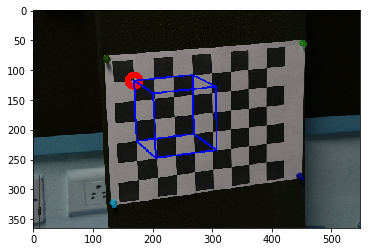

In [19]:
img_index = 0
wireframe_iamge = cv.imread(img_path[img_index])
wireframe_iamge = cv.resize(wireframe_iamge, (548, 365))
#     _3d_corners = np.float32([[0,0,0], [1,0,0], [1,0,1], [0,0,1],
#                                    [0,1,0],[1,1,0],[1,1,1],[0,1,1]])*2
_3d_corners = np.float32([[0, 0, 0], [0, 3, 0], [3, 3, 0], [3, 0, 0],
                          [0, 0, -3], [0, 3, -3], [3, 3, -3], [3, 0, -3]])
cube_corners_2d, _ = cv.projectPoints(_3d_corners, rvecs[img_index],
                                      tvecs[img_index], mtx, dist)
# print(cube_corners_2d)
cube_corners_2d = np.array(cube_corners_2d, np.int32) / 10
cube_corners_2d = np.array(cube_corners_2d, np.int32)
red = (0, 0, 255)
line_width = 2
cv.circle(wireframe_iamge, tuple(cube_corners_2d[0][0]), 10, (255, 0, 0), 10)
for i in range(4):
    cv.line(wireframe_iamge, tuple(cube_corners_2d[i][0]),
            tuple(cube_corners_2d[(i + 1) % 4][0]), red, line_width)
    cv.line(wireframe_iamge, tuple(cube_corners_2d[i][0]),
            tuple(cube_corners_2d[i + 4][0]), red, line_width)
    cv.line(wireframe_iamge, tuple(cube_corners_2d[4 + i][0]),
            tuple(cube_corners_2d[(i + 1) % 4 + 4][0]), red, line_width)
plt.imshow(wireframe_iamge)
cv.waitKey(0)
cv.destroyAllWindows()

## Results:
The cube formed is quite good in shape thus the camera matrix calculated from cv.CameraCalibrate is good.

# Question 8
The image coordinate of origin are (4800, 2163)


In [20]:
print(camera.get_image_coordinates([[0, 0, 0]]))

[[4800.39488964 2158.58816631]]


# Question 9 and 10

# Observations:
Results observed from DLT and RANSAC are satisfactory. Because I've used 33 points to calibrate camera in DLT. The camera used for images are different.  

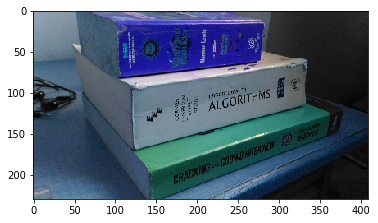

In [21]:
img = cv.imread('DLT.jpg')
img = cv.resize(img, (409, 230))
plt.imshow(img)

In [22]:
img = [(101, 18), (280, 15), (277, 60), (105, 80), (124, 92), (335, 62),
       (335, 114), (127, 169), (145, 20), (379, 124), (374, 149)]
obj = [(0, 140, -60), (165, 140, -60), (165, 92, -60), (0, 92, -60),
       (0, 92, -37), (235, 92, -37), (235, 30, -37), (0, 30, -37), (0, 30, 0),
       (270, 30, 0), (270, 0, 0)]

##  Calibration using DLT

In [23]:
camera = Camera()
A = camera.get_camera_parameters(obj, img)
camera.get_KRC()

(array([[ 72.59266334, -20.88679213, 237.94816766],
        [  0.        , 165.55041857, -33.27181919],
        [  0.        ,   0.        ,   1.        ]]),
 array([[ 0.00553474, -0.00183064,  0.00147202],
        [-0.00123941, -0.00547639, -0.00215046],
        [-0.00199548, -0.00167611,  0.0054185 ]]),
 array([[-0.6024627 ],
        [ 0.79418476],
        [ 1.        ]]))

### Error in DLT

In [24]:
predicted_point = camera.get_image_coordinates(obj)
# print(predicted_point.shape, image.shape)
print("DLT", np.mean(RMSError(img, predicted_point)))

DLT 62.276992361320936


##  Calibration using RANSAC

In [25]:
camera.RANSAC(obj, img, iterations=100)

(array([[63.16359078, -3.37845593, 94.78154176],
        [ 0.        , 53.69147646, 71.03268354],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-0.07614057,  0.00876452, -0.00794698],
        [ 0.00903744,  0.07648994, -0.00222949],
        [-0.00763519,  0.00313512,  0.07661091]]),
 array([[-1.84790468],
        [-7.72336877],
        [ 1.        ]]))

### Error in RANSAC

In [26]:
predicted_point = camera.get_image_coordinates(obj)
# print(predicted_point.shape, image.shape)
print("RANSAC", np.mean(RMSError(img, predicted_point)))

RANSAC 249.2259897021633


# Challanges
- Understanding DLT and how it is solved. Referred to sir's notes and internet for SVD
- RANSAC: The turorial helped in getting a rough idea of what RANSAC is. Later, referred to the wikipedia page to understand more.
- Zhang's Method: Used OpenCV's method's to implement Zhang's method

# Learnings
- Learn about the DLT, RANSAC and Zhang's methods for camera calibration
- Learn more about numpy and functions like flatten, etc.
- Learnt how to plot images using matplotlib